In [2]:
# Load Libraries
import pandas as pd
import pickle
from pandas import DataFrame, Series
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model, naive_bayes
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
import pybaseball as pyb
from pybaseball import statcast
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

from pybaseball import statcast
from pybaseball import  playerid_lookup
from pybaseball import  statcast_pitcher
from pybaseball import pitching_stats
from pybaseball import batting_stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from pybaseball import pitching_stats_bref

In [3]:
pyb.cache.enable()

In [100]:
data = statcast(start_dt="2023-03-30", end_dt="2023-10-24")
columns = ['player_name', 'p_throws', 'stand', 'pitch_type', 'release_speed', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'spin_axis', 'effective_speed', 'release_spin_rate', 'release_extension', 'plate_x', 'plate_z', 'description']


This is a large query, it may take a moment to complete


100%|██████████| 209/209 [00:20<00:00, 10.16it/s]


In [210]:
df = data[columns]

# **Data Cleaning**

In [211]:
# Rename columns for easier access
column_mapping = {
    'player_name': 'name',
    'p_throws': 'p_hand',
    'stand': 'batter_side',
    'pitch_type': 'pitch_type',
    'release_speed': 'velocity',
    'pfx_x': 'horizontal_break',
    'pfx_z': 'induced_vertical_break',
    'release_pos_x': 'release_side',
    'release_pos_y': 'release_dist_from_C',
    'release_pos_z': 'release_height',
    'spin_axis': 'spin_axis',
    'effective_speed': 'effective_velocity',
    'release_spin_rate': 'spin_rate',
    'release_extension': 'extension',
    'plate_x': 'pitch_height',
    'plate_z': 'pitch_side'
}

df.rename(columns=column_mapping, inplace=True)

c:\Users\genoc\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [212]:
# release side, release height, induced vertical break, extension, velocity, horizontal break, differential break, spin rate, spin axis
# pitcher name, pitcher team, pitch type

# Edit the pitcher names so the first name is first and the last name is last
df['name'] = df['name'].str.split(' ', expand=True)[1] + ' ' + df['name'].str.split(' ', expand=True)[0]

# Remove the comma from the last name
df['name'] = df['name'].replace(',', '', regex=True)

<ipython-input-212-8fbd3d1702b0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name'] = df['name'].str.split(' ', expand=True)[1] + ' ' + df['name'].str.split(' ', expand=True)[0]
<ipython-input-212-8fbd3d1702b0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name'] = df['name'].replace(',', '', regex=True)


In [213]:
columns_to_convert = ['horizontal_break', 'induced_vertical_break', 'release_height', 'release_side', 'release_dist_from_C']

df[columns_to_convert] = df[columns_to_convert] * 12

df.head()

c:\Users\genoc\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,name,p_hand,batter_side,pitch_type,velocity,horizontal_break,induced_vertical_break,release_side,release_dist_from_C,release_height,spin_axis,effective_velocity,spin_rate,extension,pitch_height,pitch_side,description
143,Paul Sewald,R,L,ST,86.8,0.6,12.84,-42.6,644.88,56.88,130,87.3,2588,6.8,0.02,2.19,hit_into_play
149,Paul Sewald,R,L,FF,93.8,-12.36,14.4,-43.2,646.8,54.84,236,93.8,2588,6.6,-0.37,3.42,foul
159,Paul Sewald,R,L,FF,93.6,-11.88,13.68,-42.48,652.92,55.92,236,92.8,2527,6.1,0.29,2.88,foul
167,Paul Sewald,R,L,FF,92.1,-8.28,14.16,-43.56,645.48,54.72,239,92.2,2588,6.7,0.21,3.22,foul
174,Paul Sewald,R,L,FF,93.0,-11.88,15.12,-42.84,652.32,56.52,237,92.5,2633,6.1,-1.08,3.82,ball


In [214]:
# Define a dictionary mapping old pitch types to new ones
pitch_type_mapping = {
    'FF': 'FB',
    'FT': 'FB',
    'SI': 'FB',
    'FC': 'FB',
    'CH': 'CH',
    'FS': 'CH',
    'CU': 'CB',
    'KC': 'CB',
    'SL': 'SL'
}

# Replace the pitch types
df['pitch_type'] = df['pitch_type'].replace(pitch_type_mapping)
print(len(df))
# Remove pitch types that are not in the mapping
df = df[df['pitch_type'].isin(pitch_type_mapping.values())]
print(len(df))

df['pitch_type'].unique()

<ipython-input-214-b3f512f1a295>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pitch_type'] = df['pitch_type'].replace(pitch_type_mapping)


728284
689151


array(['FB', 'SL', 'CB', 'CH'], dtype=object)

In [215]:
# Make horizontal break the absolute value
df['horizontal_break'] = abs(df['horizontal_break'])

# Create differential break column: induced vertical break - horizontal break
df['differential_break'] = (df['induced_vertical_break'] - df['horizontal_break']).abs()
# Calculate the average fastball velocity and movement for each pitcher
average_fastball = df[df['pitch_type'] == 'FB'].groupby('name')['velocity', 'horizontal_break', 'induced_vertical_break'].mean()

# Create new columns for the differences
df['velocity_diff'] = df['velocity'] - df['name'].map(average_fastball['velocity'])
df['horizontal_break_diff'] = df['horizontal_break'] - df['name'].map(average_fastball['horizontal_break'])
df['induced_vertical_break_diff'] = df['induced_vertical_break'] - df['name'].map(average_fastball['induced_vertical_break'])

<ipython-input-215-52f0830666ee>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_fastball = df[df['pitch_type'] == 'FB'].groupby('name')['velocity', 'horizontal_break', 'induced_vertical_break'].mean()


In [216]:
# Create columns for whiff (swing and miss) and swings
df['whiff'] = df['description'].apply(lambda x: 1 if x == "swinging_strike" or x == 'foul_tip' else 0)
df['swing'] = df['description'].apply(lambda x: 1 if x == "swinging_strike" or x == "hit_into_play" or x == "foul" or x == "foul_tip" else 0)

In [217]:
df_swing = df[df['swing'] == 1]

In [218]:
print("Difference between lengths of df and swing_df: ", len(df) - len(df_swing))
print("Amount of swings and misses: ", len(df_swing))

Difference between lengths of df and swing_df:  366118
Amount of swings and misses:  323033


In [219]:
#df.columns
df['extension'].describe()

count    688215.000000
mean          6.445758
std           0.457613
min           4.000000
25%           6.100000
50%           6.500000
75%           6.700000
max          11.700000
Name: extension, dtype: float64

In [224]:
# Delete all nan values
df_swing = df_swing.dropna()

df_swing_fb = df_swing[df_swing['pitch_type'] == 'FB']
df_swing_os = df_swing[df_swing['pitch_type'] != 'FB']

print("Amount of swings on fastballs: ", len(df_swing_fb))
print("Amount of swings on offspeed pitches: ", len(df_swing_os))

Amount of swings on fastballs:  189879
Amount of swings on offspeed pitches:  131159


# **Feature Selection**

In [228]:
df_swing_fb_r_r = df_swing_fb[(df_swing_fb['p_hand'] == 'R') & (df_swing_fb['batter_side'] == 'R')]
print(len(df_swing_fb_r_r))

# Take a random sample of 10% of the fastballs
df_swing_fb_sample = df_swing_fb_r_r.sample(frac=0.1)


#X = df_swing_fb_sample[['velocity', 'horizontal_break', 'induced_vertical_break', 'release_side', 'release_dist_from_C', 'release_height', 'spin_axis', 'effective_velocity', 'spin_rate', 'extension', 'pitch_height', 'pitch_side', 'differential_break', 'velocity_diff', 'horizontal_break_diff', 'induced_vertical_break_diff']]
X = df_swing_fb_sample[['velocity', 'horizontal_break', 'induced_vertical_break', 'release_side', 'release_dist_from_C', 'release_height', 'spin_rate', 'extension', 'differential_break']]
y = df_swing_fb_sample['whiff']

75687


In [229]:
# Assuming X is your feature matrix and y is the target variable
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for i in range(X.shape[1]):
    print(f"{X.columns[sorted_indices[i]]}: {importances[sorted_indices[i]]}")

Feature ranking:
spin_rate: 0.14656490617571782
release_side: 0.13595124137015363
release_height: 0.12517874121502623
velocity: 0.12203717366677687
horizontal_break: 0.11598331913102095
release_dist_from_C: 0.11202420531327276
induced_vertical_break: 0.1057361713834135
differential_break: 0.10246121675135614
extension: 0.03406302499326222


First run with all pitches feature importances: 

pitch_side: 0.15918781968497506
pitch_height: 0.08908142654563922
velocity_diff: 0.07200292986109903
spin_rate: 0.0675649136154043
induced_vertical_break_diff: 0.06558167095284245
release_side: 0.06404723328752208
horizontal_break_diff: 0.0625597542981824
release_height: 0.061032218805417794
induced_vertical_break: 0.053478751471834965
spin_axis: 0.05107679885974624
release_dist_from_C: 0.04944773508657053
differential_break: 0.04942184003709487
horizontal_break: 0.048209646247451624
effective_velocity: 0.044949296324100885
velocity: 0.04427459388470133
extension: 0.018083371037417324

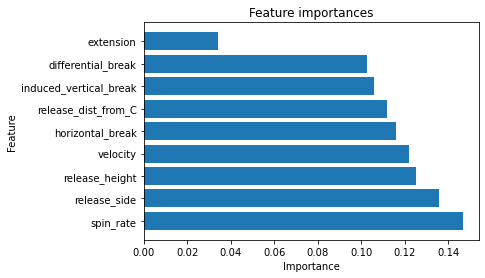

In [230]:
# Create a bar chart of feature importances
plt.barh(X.columns[sorted_indices], importances[sorted_indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature importances')
plt.show()

# **Running the Random Forest Model**

In [231]:
X = df_swing_fb[['velocity', 'horizontal_break', 'induced_vertical_break', 'release_side', 'release_dist_from_C', 'release_height', 'spin_rate', 'extension', 'differential_break']]
y = df_swing_fb['whiff']

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [233]:
model = RandomForestRegressor(n_estimators=100, random_state=1)

model.fit(X_train, y_train)


RandomForestRegressor(random_state=1)

In [237]:
predictions = model.predict(X_test)

assert len(predictions) == len(X_test)

# Add the predictions to the original DataFrame
df.loc[X_test.index, 'stuff_plus_predictions'] = predictions

ValueError: Must have equal len keys and value when setting with an iterable

In [ ]:
df['stuff_plus'].describe()